# Polinomios de Chebyshev

El objetivo de este notebook es el de obtener los polinomios de Chebyshev que aproximan las coordenadas del baricentro de la tierra en el año 2022, y tras eso evaluarlos de manera adecuada.

Para ello estos son los pasos a seguir:
 - Obtener las raices del polinomio de Chebyshev.
 - Obtener los nodos del polinomo interpolador.
 - Obtener los coeficientes del polinomio interpolador.
 - Evaluar el polinomio de Chebyshev.

Tras eso comprobaremos si los coeficientes obtenidos son correctos. Para ello calcularemos el error relativo entre las efemerides obtenidas y las efemerides que conseguimos con SPICE.jl. 

Calcularemos las efemerides con dos metodos, el primero de manera manual se podría decir resolviendo un sistema de ecuaciones y el segundo usando el algoritmo DCT. 

## Imports necesarios

In [1]:
using CSV
using JSON
using DataFrames
using Dates
using SPICE
using Plots
using FFTW;

# Datos necesarios para el proceso

Ejecutar la siguiente celda únicamente si no se tienen los datos descargados

In [ ]:
using LittleEphemeris
generate_files("/data/")

## Cargamos los Kernels que vamos a usar

Para empezar cargaremos los Kernels. Para ello haremos uso de la función del paquete SPICE.jl furnsh.

In [2]:
# Load leap seconds kernel
# Load a planetary ephemeris kernel
furnsh("data/naif0012.tls", "data/de440.bsp")

### *get_header_data*

Extrae información de un fichero JSON sobre el cuerpo deseado.

**Argumentos de entrada:** 
 - body: ID o nombre del cuerpo del que se desea.
 - file_path: Ruta del fichero que contiene la información del cuerpo.

**Argumentos de salida:**
 - first_date: Extremo izquierdo del primer intervalo de tiempo (en formato ET).
 - last_date: Extremo derecho del último intervalo de tiempo (en formato ET).
 - n_days: Número de días que abarca cada intervalo.
 - body_ID: ID del cuerpo deseado.
 - body_name: Nombre del cuerpo deseado.
 - n_coeffs: Número de coeficientes que tiene cada polinomio de Chebyshev.
 - n_sets: Número de polinomios de Chebyshev dentro de un intervalo.

In [3]:
function get_header_data(body::Union{Int, String}, file_path="data/header_data.json"::String)
    # Abrimos el fichero
    header_data = open(file_path, "r")
    # Generamos el diccionario
    header_dict = JSON.parse(header_data)
    # Cerramos el fichero
    close(header_data)
    # Obtenemos los datos generales
    first_date = header_dict["firstDate"]
    last_date = header_dict["lastDate"]
    n_days = header_dict["numberOfDays"]
    # Buscamos los datos del cuerpo solicitado
    index = 0
    try
        if typeof(body) == Int
            index = findall(x -> x["bodyID"] == body, header_dict["bodyData"])[1]
        else
            index = findall(x -> x["bodyName"] == body, header_dict["bodyData"])[1]
        end
    catch _
        error("That body isn't in the file")
    end
    body_dict = header_dict["bodyData"][index]   
    # Obtenemos los datos del cuerpo solicitado
    body_ID = body_dict["bodyID"]
    body_name = body_dict["bodyName"]
    n_coeffs = body_dict["numberOfCoeffs"]
    n_sets = body_dict["numberOfSets"]
    
    return (first_date, last_date, n_days, body_ID, body_name, n_coeffs, n_sets)
    
end

get_header_data (generic function with 2 methods)

Necesitamos los tiempos iniciales y finales de cada epoch, eso lo obtendremos del fichero time.csv con la siguiente función.

#### *get_time_vector*: 

Devuelve un vector de fechas (en formato ET) contenidas en el fichero dado. Estas fechas corresponden a los intervalos de los
polinomios de Chebyshev.

**Argumentos de entrada:**
 - initial_date: Fecha inicial, perteneciente al primer intervalo (en formato ET).
 - final_date: Fecha final, perteneciente al último intervalo (en formato ET).
 - file_path: Ruta del fichero de fechas.

**Argumentos de salida:**
 - time_vec: Vector de fechas (en formato ET).

In [4]:
function get_time_vector(initial_date::Float64, final_date::Float64, file_path="data/time.csv"::String)
    
    # Cargamos el Data Frame
    df = CSV.read(file_path, DataFrame)
    
    # Leemos los valores de los intervalos que nos interesan
    time_vec = [.0; filter(x -> initial_date < x < final_date, df[:,1]); .0]
    
    # Añadimos los extremos
    index = findall(x -> x == time_vec[2], df[:,1])[1] - 1
    time_vec[1] = df[index,1]
    index = findall(x -> x == time_vec[end-1], df[:,1])[1] + 1
    time_vec[end] = df[index,1]
    
    return time_vec
    
end

get_time_vector (generic function with 2 methods)

Ahora que tenemos las funciones para obtener los datos necesarios unicamente tenemos que llamarlas. 

In [5]:
# Cuerpo deseado
body = 3
# Obtenemos los datos del cuerpo
first_date, last_date, n_days, body_ID, body_name, n_coeffs, n_sets = get_header_data(body)

# Calculamos el número de coeficientes
p = ceil(log(2, n_coeffs))
k = Int32(2^p)

# Intervalo de tiempo que nos interesa
d0 = utc2et("2022-01-01T12:00:00")
d1 = utc2et("2023-01-01T12:00:00")

# Obtenemos el vector con las fechas del fichero
aux_time_vec = get_time_vector(d0, d1);

Ahora tenemos otro problema y es que si bien en el fichero los epoch son de 32 días, en el caso del baricentro de la tierra este tiene dos sets de coeficientes por cada epoch. Esto quiere decir que tenemos que ampliar el vector que hemos generado. Para ello calcularemos el punto medio de cada intervalo y a partir de un intervalo generaremos dos. Estos datos los guardaremos en time_vec.

In [6]:
aux_time_vec_len = length(aux_time_vec)

# Obtenemos los intervalos de los polinomios
time_vec_len = (aux_time_vec_len-1)*n_sets+1
time_vec = Vector{Float64}(undef, time_vec_len)

index = 1
midpoint = (aux_time_vec[2] - aux_time_vec[1])/n_sets
for i in 1:aux_time_vec_len-1
    time_vec[index] = aux_time_vec[i]
    for j in 1:n_sets-1
        index += 1
        time_vec[index] = aux_time_vec[i] + (midpoint * j)
    end
    index += 1
end
time_vec[end] = aux_time_vec[end];

# Método 1

## Obtener las raices del polinomio de Chebyshev.

Los nodos de Chebyshev en el intervalo $[-1, 1]$ se pueden definir mediante la siguiente función:

\begin{equation}
    x_k = \cos \left( \displaystyle\frac{2k - 1}{2n} \pi \right), k = 1, 2, \dots, n
\end{equation}

De esta formula creamos la siguiente función par la obtención de raices:

#### *chb_roots*: 

Dada una n, la función devuelve un vector con n coeficientes de Chebyshev.

**Argumentos de Entrada:**
 - n: tamaño del vector resultado.
**Argumentos de salida:**
 - x_k_veec: vector con n coeficientes de Chebyshev.

In [7]:
function chb_roots(n)
    x_k_vec = zeros(Float64, n)
    for k in 1:n
        x_k_vec[k] = cos(pi/(2*n)*(2*k-1))
    end
    return x_k_vec
end;

Para este proceso usaremos 16 nodos, esto por dos motivos, el primero es que creemos que los polinomios de Chebyshev almmacenados en los ficheros SPK son de grado 12, y más adelante usaremos la DCT (Trasnformada Discreta de Coseno) para obtener los coeficientes, la cual funciona mejor con una entrada de tamaño potencial de 2.

In [8]:
k = 16
nodes = chb_roots(k);

Las raices graficamente se verían de la siguiente manera:

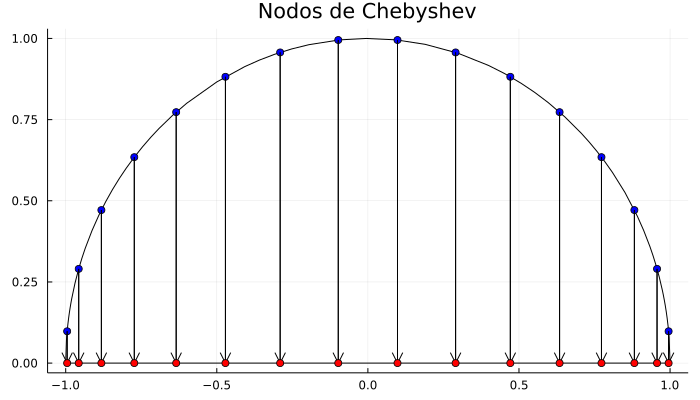

In [9]:
f(x) = sqrt(1-x^2)
g(x) = 0;

pl1 = plot(g, -1,1, label="", linecolor="black", title = "Nodos de Chebyshev", size = (700, 400))
plot!(f, label="", linecolor="black")
scatter!(nodes, f.(nodes), label="", seriescolor="blue")
quiver!(nodes, f.(nodes), quiver = (zeros(16), -f.(nodes)), linecolor="black")
scatter!(nodes, zeros(16), label="", seriescolor="red")

display(pl1)

Estas raices perteneccen al intervalo $[-1,1]$ y a nosotros nos interesa obtener las raices entre los intervalos de tiempo $[t_{j-1}, t_j]$, es por eso que tras obtener los nodos tenemos que transformarlos para que estos se adecuen a nuestro problema. Para ello tenemos la siguiente formula:

$x_k = 2 * \displaystyle\frac{t - \frac{t_{j-1} + \, t_j}{2}}{t_j - t_{j-1}} $

siendo $x_k$ un nodo de Chebyshev y $t$ el nodo equivalente dentro del intervalo $[t_{j-1}, t_j]$. Por lo que si despejamos $t$ obtenemos la siguiente formula:

$t = \displaystyle\frac{x (t_j - t_{j-1}) + t_{j-1} + t_j}{2}$

de esta formula sale la siguiente función:

#### *chb_roots2time*: 

Dado un coeficiente de Chebyshev, y los extremos de un intervalo transforma el nodo para que pertenezca al intervalo dado. (Esta función se usara con vectores).

**Argumentos de Entrada:**
 - x: coeficiente de Chebyshev.
 - t0: extremo izquierdo del intervalo.
 - t1: extremo derecho del intervalo.
**Argumentos de salida:**
 - t: el coeficiente de Chebyshev entre el intervalo t0 t1.

In [10]:
function chb_roots2time(x, t0, t1)
   
    t = x*(t1 - t0)
    t += (t0 + t1)
    t /= 2
    
    return t
end;

Más adelante necesitaremos una función que pase de tiempo a raices de Chebyshev, la función es la siguiente:

#### *time2chb_roots*: 

Dado un coeficiente de Chebyshev en el intervalo $[t0, t1]$, y los extremos del intervalo transforma el nodo para que pertenezca al intervalo $[-1,1]$. (Esta función se usara con vectores).

**Argumentos de Entrada:**
 - t: coeficiente de Chebyshev entre el intervalo t0 t1.
 - t0: extremo izquierdo del intervalo.
 - t1: extremo derecho del intervalo.
**Argumentos de salida:**
 - x: el coeficiente de Chebyshev.

In [11]:
function time2chb_roots(t, t0, t1)
    
    x = t - ((t0 + t1)/2)
    x /= (t1 - t0)
    x *= 2
    
    return x
    
end;

Ahora debemos transformar los nodos de Chebyshev para que en vez de pertenecer al intervalo $[-1,1]$ pertenezcan a los intervalos de tiempo obtenidos. Para ello haremos uso de la función creada antes (cbh_roots2time). Guardaremos el resultado en time_matrix que es una matriz en la que cada fila son los coeficientes en los intervalos obtenidos, es decir que tendrá tantas filas como segmentos y tendra $k$ columnas, siendo $k$ el número de nodos.

In [12]:
n_poly = time_vec_len-1

time_matrix = zeros(Float64, n_poly, k)

for i in 1:n_poly
    time_matrix[i,:] = chb_roots2time.(nodes, time_vec[i], time_vec[i+1])
end

## Obtener los coeficientes del polinomio interpolador

Ya tenemos las Raices, por lo que el siguiente paso es obtener los coeficientes. Para ello haremos uso de la siguiente función de interpolación:

$ P_j(t_k) = c_0 + \displaystyle\sum_{i = 1}^{d} c_i T_i(x_k) $

siendo $ c_0, c_1, \dots , c_d $ los coeficientes del polinomio interpolador, $d$ el grado del polinomio, y $T_i$ una función de evaluación.

Si lo definimos como un sistema de ecuaciones tenemos:

$P = T \cdot C$

Siendo:
 - $P$ el vector de tamaño $k$ de los valores que tendra la función en los instantes de $t$,
 - $T$ una matriz con las raices de Chebyshev evaluadas y
 - $C$ el vector de los coeficientes que queremos conseguir.
 
Por lo tanto el sistema quedaría asi:

$C = T^{-1} \cdot P$

Por lo que si queremos conseguir los coeficientes primero debemos conseguir los valores que tendra la función que queremos interpolar y hacer la función de evaluación.

### Obtener los vectores $P$ (vectores de coordenadas)

Ahora que tenemos los nodos de Chebyshev debemos obtener los valores que tendra la función que queremos interpolar en esos instantes de tiempo, es decir los valores de los vectores $P$. Para ello llamaremos a la función spkpvn del paquete Spice.jl que nos devuelve el estado del cuerpo deseado en el instante de tiempo desado. Estos valores los guardaremos en seis matrices tres para las coordenadas y tres para la velocidad. En estas matrices cada fila será un vector $P$ por lo tanto habrá tantas filas de $k$ columnas como segmentos.

In [13]:
x_p = Matrix{Float64}(undef, n_poly, k)
y_p = Matrix{Float64}(undef, n_poly, k)
z_p = Matrix{Float64}(undef, n_poly, k)
vx_p = Matrix{Float64}(undef, n_poly, k)
vy_p = Matrix{Float64}(undef, n_poly, k)
vz_p = Matrix{Float64}(undef, n_poly, k)

# Proceso de obtencion de valores de los coeficientes
handle = nothing
descr = nothing
for i in 1:n_poly
    for j in 1:k
        # Obtenemos el descriptor de segmento
        handle, descr, _ = spksfs(body_ID, time_matrix[i,j])
        # Obtenemos los valores en los nodos
        _, aux_vec, _ = spkpvn(handle, descr, time_matrix[i,j])
        # Guardamos los valores en sus respectivas Matrices
        x_p[i,j] = aux_vec[1]
        y_p[i,j] = aux_vec[2]
        z_p[i,j] = aux_vec[3]
        vx_p[i,j] = aux_vec[4]
        vy_p[i,j] = aux_vec[5]
        vz_p[i,j] = aux_vec[6]
    end
end

### Obtener la matriz $T$ (matriz de los polinomios de Chebyshev evaluados)

Para conseguir los valores de la matriz T necesitamos una función de evaluación, podemos optar por el algoritmo de Clenshaw o por la definición del Polinomio de Chebyshev. De momento usaremos la definición.

Los polinomios de Chebyshev de primer tipo son definidos mediante la relación de recurrencia

$ T_0(x) = 1 $

$ T_1(x) = x $

$ T_{n+1}(x) = 2xT_n(x) - T_{n-1}(x) $

Los cinco primeros polinomios en el intervalo $[-1,1]$ se verían de la siguiente manera:

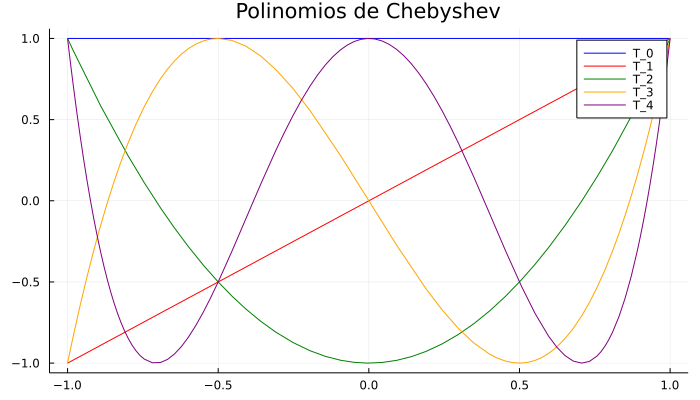

In [14]:
T0(x) = 1
T1(x) = x
T2(x) = 2x^2 -1
T3(x) = 4x^3 - 3x
T4(x) = 8x^4 - 8x^2 +1

pl2 = plot(T0, -1,1, linecolor="blue", label="T_0", title="Polinomios de Chebyshev", size = (700, 400))
plot!(T1, -1,1, linecolor="red", label="T_1")
plot!(T2, -1,1, linecolor="green", label="T_2")
plot!(T3, -1,1, linecolor="orange", label="T_3")
plot!(T4, -1,1, linecolor="purple", label="T_4")

La siguiente función nos permite evaluar un polinomio de Chebyshev del grado deseado en el instante deseado entre los valores $[-1,1]$

In [15]:
function Tfcn(x,d)
    Tlist = zeros(d+1)
    Tlist[1] = 1
    Tlist[2] = x
    for j in 2:d
        Tlist[j+1] = 2*x*Tlist[j] - Tlist[j-1]
    end
    return Tlist
end;

Por cada raiz de Chebyshev conseguimos un vector Tlist de tamaño $d$ (en este caso $d = k$), es decir un vector de tamaño $k$. Teniendo $k$ coeficientes conseguimos una matriz en la que cada fila es un vector Tlist. Es decir una matriz de $k$ filas y $k$ columnas.

In [16]:
t_matrix = Matrix{Float64}(undef, k, k)
for i in 1:k
    t_matrix[i,:] = Tfcn(nodes[i],k-1)
end;

### Obtener los coeficientes.

Ahora que ya tenemos el vector $P$ y la matriz $T$ solo tenemos que resolver el sistema mencionado anteriormente para obtener los coeficientes.

In [17]:
# Matrices con los coeficientes
x_coeffs = Matrix{Float64}(undef, n_poly, k)
y_coeffs = Matrix{Float64}(undef, n_poly, k)
z_coeffs = Matrix{Float64}(undef, n_poly, k)
vx_coeffs = Matrix{Float64}(undef, n_poly, k)
vy_coeffs = Matrix{Float64}(undef, n_poly, k)
vz_coeffs = Matrix{Float64}(undef, n_poly, k)

inv_t = inv(t_matrix)

for i in 1:n_poly
    x_coeffs[i,:] = inv_t * x_p[i,:]
    y_coeffs[i,:] = inv_t * y_p[i,:]
    z_coeffs[i,:] = inv_t * z_p[i,:]
    vx_coeffs[i,:] = inv_t * vx_p[i,:]
    vy_coeffs[i,:] = inv_t * vy_p[i,:]
    vz_coeffs[i,:] = inv_t * vz_p[i,:]
end;

## Comprobación de los coeficientes.

Para la comprobación de los coeficientes crearemos una función *get_pos* que dados un vector de fechas, y los coeficientes de Chebyshev obtendrá el valor del polinomio en las fechas.

#### *get_pos*: 

Dados un tiempo, y los coeficientes de Chebyshev, el intervalo que abarca el polinomio, y el grado de este, evalua el polinomio en el tiempo dado.

**Argumentos de Entrada:**
 - t: tiempo en el que queremos evaluar el polinomio de Chebyshev.
 - t_init: tiempo inicial que abarca el intervalo que interpola el polinomio de Chebyshev.
 - t_end: tiempo final que abarca el intervalo que interpola el polinomio de Chebyshev.
 - chb_coeffs: coeficientes del polinomio de Chebyshev que queremos evaluar.
 - degree: grado del polinomio de Chebyshev.
**Argumentos de salida:**
 - pos: el valor del polinomio en el instante t.

In [18]:
function get_pos(t::Float64, t_init::Float64, t_end::Float64, chb_coeffs::Vector{Float64}, degree::Int)
    
    x_k = time2chb_roots(t, t_init, t_end)
    T = Tfcn(x_k, degree-1)'
    
    pos = T*chb_coeffs
    
    return pos
    
end;

#### *get_pos*: 

Dados un vector de tiempos, y los coeficientes de Chebyshev, los intervalos que abarcan los polinomios, evalua el polinomio en los tiempos dado.

**Argumentos de Entrada:**
 - date_vector: vector de instantes en los que queremos evaluar los polinomios.
 - epoch_time_vector: vector de intervalos de tiempo que interpolan los polinomios de Chebyshev. Debe haber tantos intervalos como polinomios.
 - chb_coeffs: vector de los coeficientes de los polinomios de Chebysev. Todos los coeficientes deveran ser del mismo grado.
**Argumentos de salida:**
 - pos: vector con los polinomios evaluados en los instantes de date_vector.

In [19]:
function get_pos(date_vector::Vector{Float64}, epoch_time_vector::Vector{Float64}, chb_coeffs::Vector{Matrix{Float64}})
    
    n_dates = length(date_vector)
    n_epoches = length(epoch_time_vector)-1
    n_coeffs_types = length(chb_coeffs)
    
    n_coeffs_groups, d = size(chb_coeffs[1])
    if n_epoches != n_coeffs_groups
        error("The number of time intervals and the number of groups of Chebyshev coefficients are different")
    end
    
    
    pos_vec = Matrix{Float64}(undef, n_coeffs_types, n_dates)
    
    for dt_index in 1:n_dates
        dt = date_vector[dt_index]
        i = 1
        found = false
        while !found && i <= n_epoches
            if epoch_time_vector[i] <= dt <= epoch_time_vector[i+1]
                for j in 1:n_coeffs_types
                    pos_vec[j,dt_index] = get_pos(dt, epoch_time_vector[i], epoch_time_vector[i+1], chb_coeffs[j][i,:], d)
                end
                found = true
            else
                i += 1
            end
        end
        if !found
            error("date out of range")
        end
    end
    
    return pos_vec
    
end;

Ahora que tenemos la función que nos devuelve las efemerides para los instante deseados, tenemos que generar un vector de tiempo que usaremos para obtener las efemerides de dos maneras diferentes. La primera manualmente con la funcion que acabamos de crear y la segunda con el paquete SPICE.jl.

In [20]:
date_range = range(time_vec[1], time_vec[end], length=1000)
date_vec = collect(date_range);

### Metodo manual:
Generamos los vectores de coordenadas con la función que hemos creado anteriormente

In [21]:
chb_coeffs = [x_coeffs, y_coeffs, z_coeffs, vx_coeffs, vy_coeffs, vz_coeffs]

pos_vec = get_pos(date_vec, time_vec, chb_coeffs)
x = pos_vec[1,:]
y = pos_vec[2,:]
z = pos_vec[3,:]
vx = pos_vec[4,:]
vy = pos_vec[5,:]
vz = pos_vec[6,:];

### Método SPICE.jl
Generamos los vectores de coordenadas con la función de SPICE.jl

In [22]:
len = length(date_vec)

x_spice = Vector{Float64}(undef, len)
y_spice = Vector{Float64}(undef, len)
z_spice = Vector{Float64}(undef, len)
vx_spice = Vector{Float64}(undef, len)
vy_spice = Vector{Float64}(undef, len)
vz_spice = Vector{Float64}(undef, len)

for i in 1:len
    # Obtenemos el descriptor de segmento
    handle, descr, _ = spksfs(body_ID, date_vec[i])
    # Obtenemos los valores en los nodos
    _, aux_vec, _ = spkpvn(handle, descr, date_vec[i])
    x_spice[i] = aux_vec[1]
    y_spice[i] = aux_vec[2]
    z_spice[i] = aux_vec[3]
    vx_spice[i] = aux_vec[4]
    vy_spice[i] = aux_vec[5]
    vz_spice[i] = aux_vec[6]
end

### Calculamos el error
Cálculamos error relativo entre ambos vectores de coordenadas y lo mostramos gráficamente.

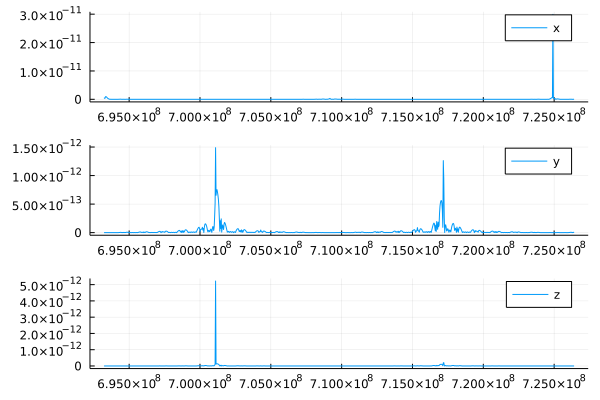

In [23]:
# Calculamos el error relativo
error_x = abs.(x-x_spice)./abs.(x_spice)
error_y = abs.(y-y_spice)./abs.(z_spice)
error_z = abs.(z-z_spice)./abs.(y_spice)

# Mostramos una gráfica del error
plx = plot(date_vec, error_x, label = "x")
ply = plot(date_vec, error_y, label = "y")
plz = plot(date_vec, error_z, label = "z")
plot(plx, ply, plz, layout = (3, 1))

Cálculamos error relativo entre ambos vectores de velociudades y lo mostramos gráficamente.

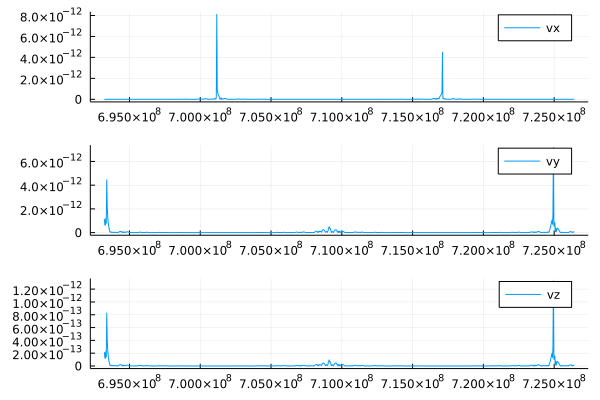

In [24]:
# Calculamos el error relativo
error_vx = abs.(vx-vx_spice)./abs.(vx_spice)
error_vy = abs.(vy-vy_spice)./abs.(vz_spice)
error_vz = abs.(vz-vz_spice)./abs.(vy_spice)

# Mostramos una gráfica del error
plx = plot(date_vec, error_vx, label = "vx")
ply = plot(date_vec, error_vy, label = "vy")
plz = plot(date_vec, error_vz, label = "vz")
plot(plx, ply, plz, layout = (3, 1))

No somos capaces de ver el valor del error por lo que veremos las gráficas en escala logaríttmica

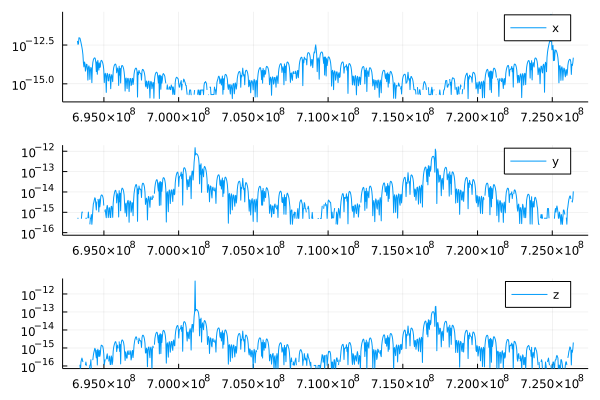

┌ Warning: Invalid negative or zero value 0.0 found at series index 180 for log10 based yscale
└ @ Plots /home/aitor/.julia/packages/Plots/YAlrZ/src/utils.jl:95
┌ Warning: Invalid negative or zero value 0.0 found at series index 4 for log10 based yscale
└ @ Plots /home/aitor/.julia/packages/Plots/YAlrZ/src/utils.jl:95
┌ Warning: Invalid negative or zero value 0.0 found at series index 1 for log10 based yscale
└ @ Plots /home/aitor/.julia/packages/Plots/YAlrZ/src/utils.jl:95


In [25]:
# Mostramos una gráfica del error
plx = plot(date_vec, error_x, yaxis=(:log10, [1e-16, :auto]), label = "x")
ply = plot(date_vec, error_y, yaxis=(:log10, [1e-16, :auto]), label = "y")
plz = plot(date_vec, error_z, yaxis=(:log10, [1e-16, :auto]), label = "z")
plot(plx, ply, plz, layout = (3, 1))

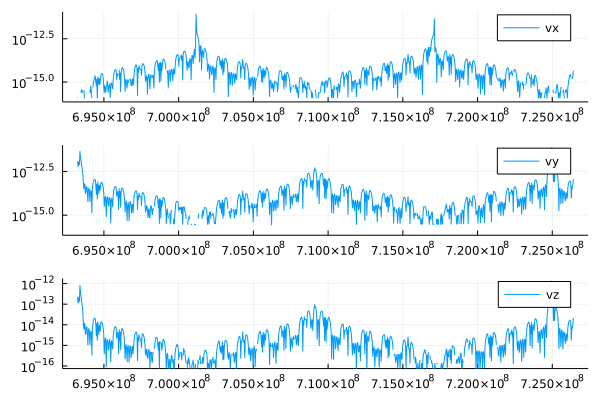

┌ Warning: Invalid negative or zero value 0.0 found at series index 3 for log10 based yscale
└ @ Plots /home/aitor/.julia/packages/Plots/YAlrZ/src/utils.jl:95
┌ Warning: Invalid negative or zero value 0.0 found at series index 155 for log10 based yscale
└ @ Plots /home/aitor/.julia/packages/Plots/YAlrZ/src/utils.jl:95
┌ Warning: Invalid negative or zero value 0.0 found at series index 155 for log10 based yscale
└ @ Plots /home/aitor/.julia/packages/Plots/YAlrZ/src/utils.jl:95


In [26]:
# Mostramos una gráfica del error
plx = plot(date_vec, error_vx, yaxis=(:log10, [1e-16, :auto]), label = "vx")
ply = plot(date_vec, error_vy, yaxis=(:log10, [1e-16, :auto]), label = "vy")
plz = plot(date_vec, error_vz, yaxis=(:log10, [1e-16, :auto]), label = "vz")
plot(plx, ply, plz, layout = (3, 1))

El Warning es normal, no es nada preocupante ocurre debido a que el logaritmo de 0 es indeterminado.

# Método 2

## Interpolación polinómica para nodos de Chebyshev en el intervalo (ta,tb) mediante a DCT

#### *ChebyshevNodes*: 

Dados el grado y el intervalo en el que queremos obtener los nodos de Chebyshev, esta función devuelve los nodos correspondientes.

**Argumentos de Entrada:**
 - N: Grado de los nodos de Chebyshev.
 - tspan: intervalo en el que queremos los nodos de Chebysev. tspan=$(t_a, t_b) \in \mathbb{R}^2$ ($t_a < t_b$), $N \in \mathbb{N}$. (Valor por defecto, $t_a=-1$, $t_b = 1$).
**Argumentos de salida:**
 - $tt$: vector, $t_1,\ldots,t_n$ donde sus elementos son los nodos de Chebyshev en el intervalo $[t_a,t_b]$.

In [27]:
function ChebyshevNodes(N, tspan=(-1.,1.))
    thetas =  range(1,2N-1,step=2)/(2N)
    ta = tspan[1]
    tb = tspan[2]
    A = (ta+tb)/2
    B = (tb-ta)/2
    tt = Array{Float64}(undef,N)
    @. tt = A - B*cos(π*thetas)  # nodos de interpolación de Chebyshev
    return tt
end;

Anteriormente ya hemos conseguido los intervalos de tiempo para los que queremos obtener los polinomios de Chebyshev. Así que los usaremos para conseguir los nodos con este nuevo metodo.

In [28]:
k = 16
n_epoch = length(time_vec)-1
chb_nodes = Matrix{Float64}(undef, n_epoch, k)
tt = Matrix{Float64}(undef, n_epoch, k)

for i in 1:n_epoch
    chb_nodes[i,:] = ChebyshevNodes(16, (time_vec[i], time_vec[i+1]))
end

Supongamos que queremos aproximar la función $f(t)$ en el intervalo $[t_a,t_b]$ para los nodos de Chebyshev en ese intervalo mediante un polinomio interpolador $P(t)$.

#### *ChebyshevCoeffs*: 

Dada una tabla con valores de la función que queremos aproximar en los nodos de Chebyshev devuelve los coeficientes del polinomio interpolador.

**Argumentos de Entrada:**
 - $ff$: Tabla con componentes de la función $f(t)$ $(f_1, f_2, \ldots, f_{N})$ que queremos aproximar en los nodos de Chebyshev del intervalo $[t_a,t_b]$.
**Argumentos de salida:**
 - $hf$: vector de coeficientes del polinomio interpolador, $(\hat f_1, \hat f_2, \ldots, \hat f_{N})$. El polinomio interpolador mencionado arriba, se puede representar asi:
$$ 
P(t) = \frac{1}{\sqrt{2}}\, \hat f_1 + \sum_{k=1}^{N-1} \hat f_{k+1}\, T_k((A-t)/B), \tag{1}
$$
donde $A=(t_a+t_b)/2$, $B = (t_b-t_a)/2$, y $T_k(x)$ ($k=1,\ldots,N-1$) son polinomios de Chebyshev (de primer tipo), es decir, $T_k(x) = \cos(k\, \arccos(x))$.

In [29]:
function ChebyshevCoeffs(ff)
    N = length(ff)
    hf = dct(ff)*sqrt(2/N)
    return hf
end;

Lo primero que tenemos que hacer es conseguir los valores de la función que queremos interpolar en los nodos. Lo hacemos igual que en el primer metodo pero con los nuevos nodos.

In [30]:
x_p = Matrix{Float64}(undef, n_poly, k)
y_p = Matrix{Float64}(undef, n_poly, k)
z_p = Matrix{Float64}(undef, n_poly, k)
vx_p = Matrix{Float64}(undef, n_poly, k)
vy_p = Matrix{Float64}(undef, n_poly, k)
vz_p = Matrix{Float64}(undef, n_poly, k)

# Proceso de obtencion de valores de los coeficientes
handle = nothing
descr = nothing
for i in 1:n_poly
    for j in 1:k
        # Obtenemos el descriptor de segmento
        handle, descr, _ = spksfs(body_ID, chb_nodes[i,j])
        # Obtenemos los valores en los nodos
        _, aux_vec, _ = spkpvn(handle, descr, chb_nodes[i,j])
        # Guardamos los valores en sus respectivas Matrices
        x_p[i,j] = aux_vec[1]
        y_p[i,j] = aux_vec[2]
        z_p[i,j] = aux_vec[3]
        vx_p[i,j] = aux_vec[4]
        vy_p[i,j] = aux_vec[5]
        vz_p[i,j] = aux_vec[6]
    end
end

Una vez que tenemos el valor de los nodos vamos a obtener los coeficientes con el nuevo metodo.

In [31]:
# Matrices con los coeficientes
x_coeffs = Matrix{Float64}(undef, n_poly, k)
y_coeffs = Matrix{Float64}(undef, n_poly, k)
z_coeffs = Matrix{Float64}(undef, n_poly, k)
vx_coeffs = Matrix{Float64}(undef, n_poly, k)
vy_coeffs = Matrix{Float64}(undef, n_poly, k)
vz_coeffs = Matrix{Float64}(undef, n_poly, k)

for i in 1:n_epoch
    x_coeffs[i,:] = ChebyshevCoeffs(x_p[i,:])
    y_coeffs[i,:] = ChebyshevCoeffs(y_p[i,:])
    z_coeffs[i,:] = ChebyshevCoeffs(z_p[i,:])
    vx_coeffs[i,:] = ChebyshevCoeffs(vx_p[i,:])
    vy_coeffs[i,:] = ChebyshevCoeffs(vy_p[i,:])
    vz_coeffs[i,:] = ChebyshevCoeffs(vz_p[i,:])
end

#### *ChebyshevEval*: 

La siguiente función evalua el polinomio interpolador para una t dada en el intervalo indicado.

**Argumentos de Entrada:**
  - $hf$: Vector de coeficientes del polinomio interpolador.
  - t: instante en el que queremos evaluar el polinomio.
  - tspan: intervalo al que pertenece el polinomio interpolador.
**Argumentos de salida:**
  - $f(t)$: siendo $f$ la función que queremos interpolar.

In [32]:
function ChebyshevEval(hf,t::Float64, tspan=(-1.,1.))
    # Algoritmo de Clenshaw
    N = length(hf)
    ta = tspan[1]
    tb = tspan[2]
    A = (ta+tb)/2
    B = (tb-ta)/2
    x = (A-t)/B
    x2 = 2*x
    b = 0.
    b_ = hf[N]
    for k in N-1:-1:2
        aux = hf[k] + x2*b_ - b
        b = b_
        b_ = aux
    end
    return sqrt(2)/2*hf[1] + x*b_ - b
end;

#### *get_pos2*: 

Dados un vector de tiempos, y los coeficientes de Chebyshev, los intervalos que abarcan los polinomios, evalua el polinomio en los tiempos dado.

**Argumentos de Entrada:**
 - date_vector: vector de instantes en los que queremos evaluar los polinomios.
 - epoch_time_vector: vector de intervalos de tiempo que interpolan los polinomios de Chebyshev. Debe haber tantos intervalos como polinomios.
 - chb_coeffs: vector de los coeficientes de los polinomios de Chebysev. Todos los coeficientes deveran ser del mismo grado.
**Argumentos de salida:**
 - pos: vector con los polinomios evaluados en los instantes de date_vector.

In [33]:
function get_pos2(date_vector::Vector{Float64}, epoch_time_vector::Vector{Float64}, chb_coeffs::Vector{Matrix{Float64}})
    
    n_dates = length(date_vector)
    n_epoches = length(epoch_time_vector)-1
    n_coeffs_types = length(chb_coeffs)
    
    n_coeffs_groups, d = size(chb_coeffs[1])
    if n_epoches != n_coeffs_groups
        error("the number of time intervals and the number of groups of Chebyshev coefficients are different")
    end
    
    
    pos_vec = Matrix{Float64}(undef, n_coeffs_types, n_dates)
    
    for dt_index in 1:n_dates
        dt = date_vector[dt_index]
        i = 1
        found = false
        while !found && i <= n_epoches
            if epoch_time_vector[i] <= dt <= epoch_time_vector[i+1]
                for j in 1:n_coeffs_types
                    pos_vec[j,dt_index] = ChebyshevEval(chb_coeffs[j][i,:], dt, (epoch_time_vector[i], epoch_time_vector[i+1]))
                end
                found = true
            else
                i += 1
            end
        end
        if !found
            error("date out of range")
        end
    end
    
    return pos_vec
    
end;

Ahora solo tenemos que evaluar los coeficientes que hemos obtenido anteriormente.

In [34]:
chb_coeffs = [x_coeffs, y_coeffs, z_coeffs, vx_coeffs, vy_coeffs, vz_coeffs]

pos_vec2 = get_pos2(date_vec, time_vec, chb_coeffs)
x2 = pos_vec2[1,:]
y2 = pos_vec2[2,:]
z2 = pos_vec2[3,:]
vx2 = pos_vec2[4,:]
vy2 = pos_vec2[5,:]
vz2 = pos_vec2[6,:];

### Calculamos el error
Cálculamos error relativo entre ambos vectores de coordenadas y lo mostramos gráficamente.

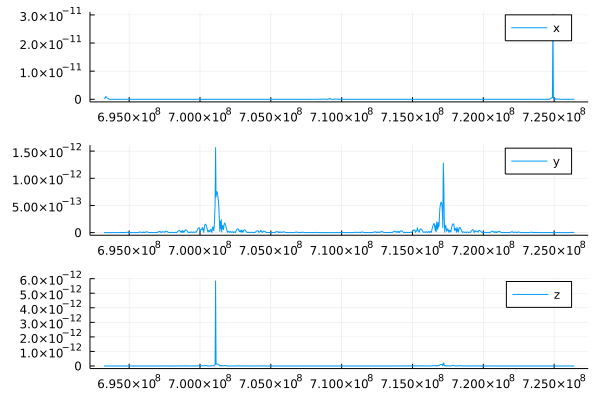

In [35]:
# Calculamos el error relativo
error_x = abs.(x2-x_spice)./abs.(x_spice)
error_y = abs.(y2-y_spice)./abs.(z_spice)
error_z = abs.(z2-z_spice)./abs.(y_spice)

# Mostramos una gráfica del error
plx = plot(date_vec, error_x, label = "x")
ply = plot(date_vec, error_y, label = "y")
plz = plot(date_vec, error_z, label = "z")
plot(plx, ply, plz, layout = (3, 1))

Cálculamos error relativo entre ambos vectores de velociudades y lo mostramos gráficamente.

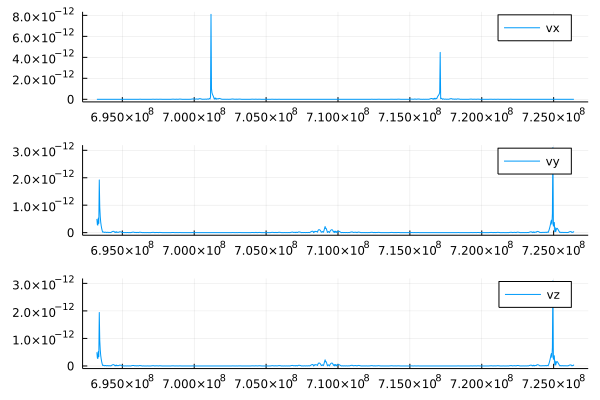

In [36]:
# Calculamos el error relativo
error_vx = abs.(vx2-vx_spice)./abs.(vx_spice)
error_vy = abs.(vy2-vy_spice)./abs.(vy_spice)
error_vz = abs.(vz2-vz_spice)./abs.(vz_spice)

# Mostramos una gráfica del error
plx = plot(date_vec, error_vx, label = "vx")
ply = plot(date_vec, error_vy, label = "vy")
plz = plot(date_vec, error_vz, label = "vz")
plot(plx, ply, plz, layout = (3, 1))

No somos capaces de ver el valor del error por lo que veremos las gráficas en escala logaríttmica

┌ Warning: Invalid negative or zero value 0.0 found at series index 101 for log10 based yscale
└ @ Plots /home/aitor/.julia/packages/Plots/YAlrZ/src/utils.jl:95
┌ Warning: Invalid negative or zero value 0.0 found at series index 2 for log10 based yscale
└ @ Plots /home/aitor/.julia/packages/Plots/YAlrZ/src/utils.jl:95


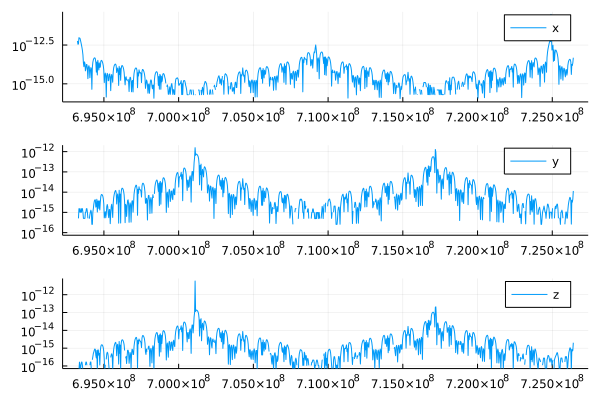

┌ Warning: Invalid negative or zero value 0.0 found at series index 2 for log10 based yscale
└ @ Plots /home/aitor/.julia/packages/Plots/YAlrZ/src/utils.jl:95


In [37]:
# Mostramos una gráfica del error
plx = plot(date_vec, error_x, yaxis=(:log10, [1e-16, :auto]), label = "x")
ply = plot(date_vec, error_y, yaxis=(:log10, [1e-16, :auto]), label = "y")
plz = plot(date_vec, error_z, yaxis=(:log10, [1e-16, :auto]), label = "z")
plot(plx, ply, plz, layout = (3, 1))

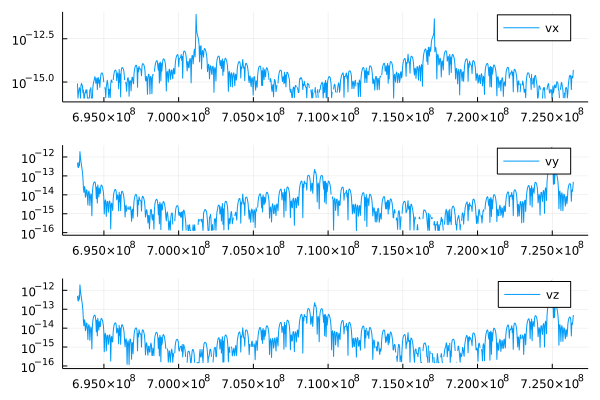

┌ Warning: Invalid negative or zero value 0.0 found at series index 55 for log10 based yscale
└ @ Plots /home/aitor/.julia/packages/Plots/YAlrZ/src/utils.jl:95
┌ Warning: Invalid negative or zero value 0.0 found at series index 101 for log10 based yscale
└ @ Plots /home/aitor/.julia/packages/Plots/YAlrZ/src/utils.jl:95
┌ Warning: Invalid negative or zero value 0.0 found at series index 180 for log10 based yscale
└ @ Plots /home/aitor/.julia/packages/Plots/YAlrZ/src/utils.jl:95


In [38]:
# Mostramos una gráfica del error
plx = plot(date_vec, error_vx, yaxis=(:log10, [1e-16, :auto]), label = "vx")
ply = plot(date_vec, error_vy, yaxis=(:log10, [1e-16, :auto]), label = "vy")
plz = plot(date_vec, error_vz, yaxis=(:log10, [1e-16, :auto]), label = "vz")
plot(plx, ply, plz, layout = (3, 1))

Ahora calculamos el error relativo entre ambos metodos para comprobar que no den el mismo resultado exacto.

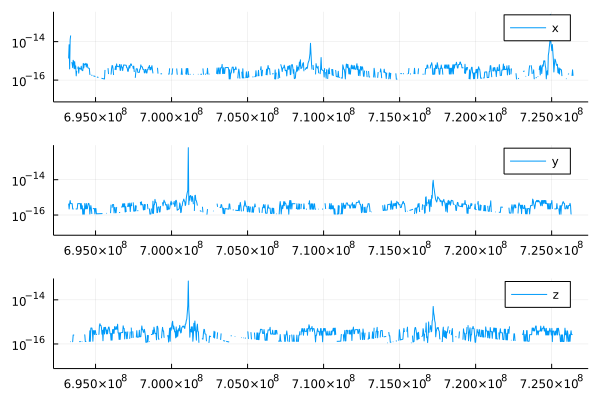

┌ Warning: Invalid negative or zero value 0.0 found at series index 6 for log10 based yscale
└ @ Plots /home/aitor/.julia/packages/Plots/YAlrZ/src/utils.jl:95
┌ Warning: Invalid negative or zero value 0.0 found at series index 12 for log10 based yscale
└ @ Plots /home/aitor/.julia/packages/Plots/YAlrZ/src/utils.jl:95
GKS: Number of points is invalid in routine POLYLINE
┌ Warning: Invalid negative or zero value 0.0 found at series index 2 for log10 based yscale
└ @ Plots /home/aitor/.julia/packages/Plots/YAlrZ/src/utils.jl:95


In [39]:
error_x2 = abs.(x2-x)./abs.(x)
error_y2 = abs.(y2-y)./abs.(y)
error_z2 = abs.(z2-z)./abs.(z)

plx = plot(date_vec, error_x2, yaxis=(:log10, [1e-17, :auto]), label = "x")
ply = plot(date_vec, error_y2, yaxis=(:log10, [1e-17, :auto]), label = "y")
plz = plot(date_vec, error_z2, yaxis=(:log10, [1e-17, :auto]), label = "z")
plot(plx, ply, plz, layout = (3, 1))

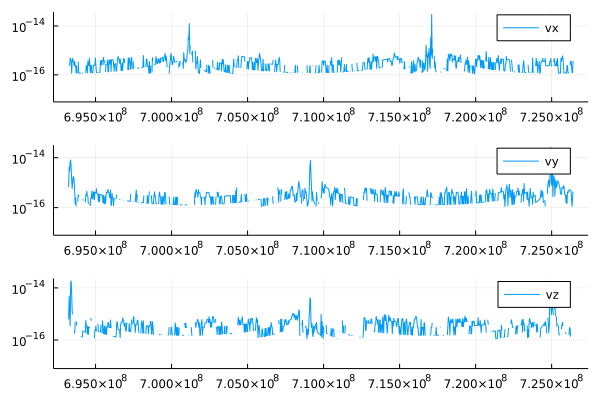

┌ Warning: Invalid negative or zero value 0.0 found at series index 2 for log10 based yscale
└ @ Plots /home/aitor/.julia/packages/Plots/YAlrZ/src/utils.jl:95
┌ Warning: Invalid negative or zero value 0.0 found at series index 17 for log10 based yscale
└ @ Plots /home/aitor/.julia/packages/Plots/YAlrZ/src/utils.jl:95
┌ Warning: Invalid negative or zero value 0.0 found at series index 10 for log10 based yscale
└ @ Plots /home/aitor/.julia/packages/Plots/YAlrZ/src/utils.jl:95
GKS: Number of points is invalid in routine POLYLINE


In [40]:
error_vx2 = abs.(vx2-vx)./abs.(vx)
error_vy2 = abs.(vy2-vy)./abs.(vy)
error_vz2 = abs.(vz2-vz)./abs.(vz)

plx = plot(date_vec, error_vx2, yaxis=(:log10, [1e-17, :auto]), label = "vx")
ply = plot(date_vec, error_vy2, yaxis=(:log10, [1e-17, :auto]), label = "vy")
plz = plot(date_vec, error_vz2, yaxis=(:log10, [1e-17, :auto]), label = "vz")
plot(plx, ply, plz, layout = (3, 1))

## Documentación de funciones utilizadas del paquete Spice

 - furnsh: https://naif.jpl.nasa.gov/pub/naif/toolkit_docs/C/cspice/furnsh_c.html
 - spklef: https://naif.jpl.nasa.gov/pub/naif/toolkit_docs/C/cspice/spklef_c.html
 - unitim: https://naif.jpl.nasa.gov/pub/naif/toolkit_docs/C/cspice/unitim_c.html
 - et2utc: https://naif.jpl.nasa.gov/pub/naif/toolkit_docs/C/cspice/et2utc_c.html
 - spkpos: https://naif.jpl.nasa.gov/pub/naif/toolkit_docs/C/cspice/spkpos_c.html